In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time

from util import *
from data_loader import * 
import scdd as sd
import dist_deconv_1d as dd1d

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
data_13m = load_10x_1_3mil()
sc.pp.filter_genes(data_13m,min_counts=10*data_13m.shape[0])

In [2]:
data_13m = load_10x_8k()
sc.pp.filter_genes(data_13m,min_counts=5*data_13m.shape[0])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
Nc,G = data_13m.shape
Nr = data_13m.X.sum()/Nc
B = Nc*Nr
Nr_bar = Nr/G
print(B,Nc,Nr,Nr_bar)

22912968.0 8381 2733.9181481923397 19.811001073857533


In [4]:
B_sub_list = [int(B/10000),int(B/5000),int(B/2000),int(B/1000)]
param=[]
for B_sub in B_sub_list:
    for Nr_bar in [0.5,1,2,3,4,5,8,10]:
        param.append((B_sub,Nr_bar,Nr_bar*G,int(B_sub/Nr_bar/G)))

In [5]:
data_subsamp = {}
for i in range(len(param)):
    _,Nr_bar_,Nr_,Nc_ = param[i]
    data_subsamp[param[i]]=sd.subsamp_anndata(data_13m,Nr_,Nc_)

AttributeError: module 'scdd' has no attribute 'subsamp_anndata'

# density deconvolution 

In [171]:
data_13m.var_names

Index(['Rpl7', 'Rpl37a', 'Ptma', 'H3f3a', 'Rpl39', 'Rpl10', 'Rps4x', 'Tmsb4x',
       'Rps3a1', 'Rps27', 'Rps8', 'Marcksl1', 'Stmn1', 'Rpl11', 'Rpl9',
       'Rplp0', 'Rpl6', 'Actb', 'Rpl21', 'Tmsb10', 'Rpl32', 'Rps9', 'Rps5',
       'Rps19', 'Rps16', 'Rps11', 'Rpl13a', 'Ftl1', 'Rps3', 'Hbb-bs', 'Rps15a',
       'Fabp7', 'Rpl41', 'Rpl18a', 'Rpl13', 'Tubb3', 'Rps24', 'Tpt1', 'Hspa8',
       'Eef1a1', 'Ppia', 'Rps27a', 'Hba-a1', 'Hba-a2', 'Ubb', 'Rpl26', 'Rpl23',
       'Rpl19', 'Rpl38', 'H3f3b', 'Actg1', 'Tubb2b', 'Rps23', 'Sox11', 'Rps7',
       'Rps29', 'Rpl37', 'Tuba1a', 'Rps2', 'Rps18', 'Tubb5', 'Hsp90ab1',
       'Rps14', 'Rpl17', 'Malat1', 'mt-Nd1', 'mt-Co1', 'mt-Co2', 'mt-Atp6',
       'mt-Co3', 'mt-Nd4', 'mt-Cytb'],
      dtype='object')

In [172]:
gene = data_13m.var_names[2]
temp_full = data_13m[:,gene].X
temp_full = np.array(temp_full,dtype=int)
temp_full = temp_full.reshape(-1)

temp = data_subsamp[list(data_subsamp.keys())[5]][:,gene].X
temp = np.array(temp,dtype=int)
temp = temp.reshape(-1)

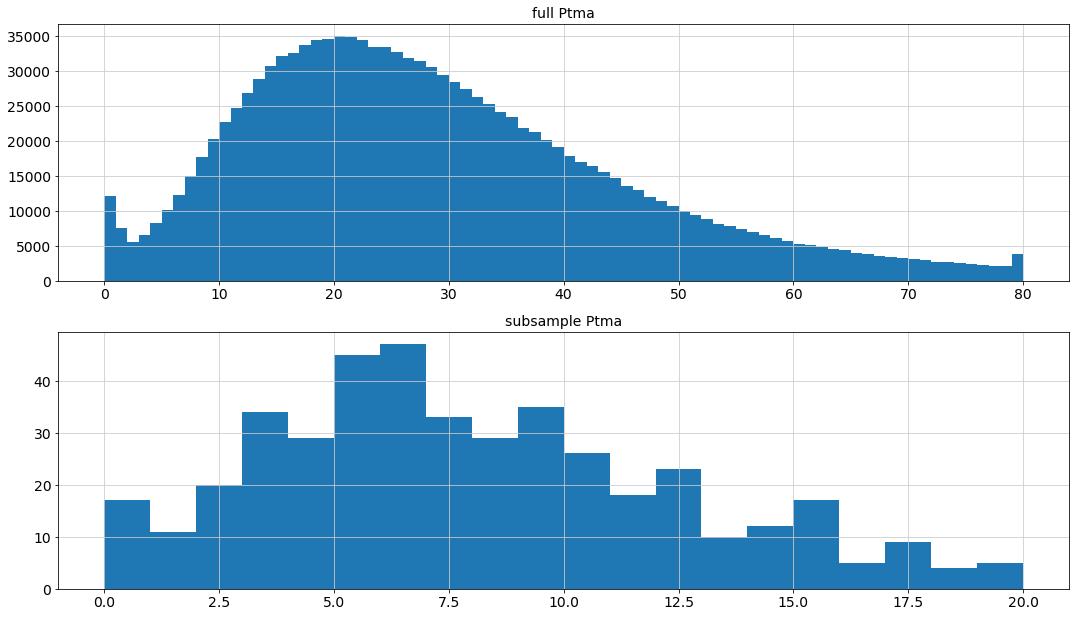

In [175]:
plt.figure(figsize=[18,10])
plt.subplot(211)
plt.hist(temp_full,bins=np.linspace(0,80,81))
plt.title('full %s'%gene)
plt.subplot(212)
plt.hist(temp,bins=np.linspace(0,20,21))
plt.title('subsample %s'%gene)
plt.show()

In [176]:
p_hat,x_hat=dd1d.dd_1d(temp,noise='poi',zero_inflate=True,c_reg=1e-6,verbose=False,gamma=None,debug_mode=False)

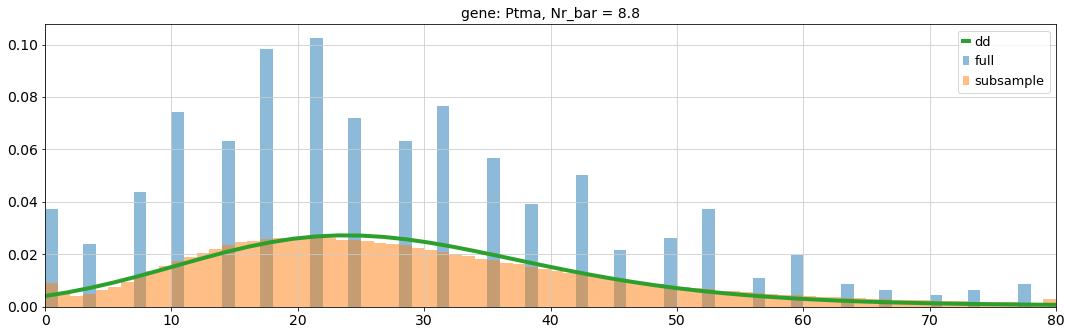

In [178]:
m_full = temp_full.mean()
m_sub = temp.mean()
m_hat = p_hat.dot(x)
x_rec = x/m_hat*m_full
x_step = x_rec[1]-x_rec[0]
plt.figure(figsize=[18,5])
plt.hist(temp*m_full/m_sub,bins=np.linspace(0,80,81),weights = np.ones(temp.shape[0])/temp.shape[0],alpha=0.5,label='full')
plt.hist(temp_full,bins=np.linspace(0,80,81),weights = np.ones(temp_full.shape[0])/temp_full.shape[0],alpha=0.5,label='subsample')
plt.plot(x_rec,p_hat/x_step,linewidth=4,label='dd')
plt.title('gene: %s, Nr_bar = %0.1f'%(gene,temp.mean()))
plt.xlim([0,80])
plt.legend()
plt.show()

In [160]:
# gene_list = list(data_13m.var_names[0:4])
gene_list = list(data_13m.var_names)
err_dd_dic_ = {}
err_ml_dic_ = {}
for key in data_subsamp.keys():
    err_dd_dic_[key] = np.zeros(len(gene_list))
    err_ml_dic_[key] = np.zeros(len(gene_list))

In [161]:
for i_gene,gene in enumerate(gene_list):
    temp_full = data_13m[:,gene].X
    temp_full = np.array(temp_full,dtype=int)
    temp_full = temp_full.reshape(-1)
    p_full,x_full=dd1d.counts2pdf_1d(temp_full)
    
    for key in data_subsamp.keys():
#         B_,Nr_bar_,Nr_,Nc_ = key
        temp = data_subsamp[key][:,gene].X
        temp = np.array(temp,dtype=int)
        temp = temp.reshape(-1)

        p_sub,x_sub=dd1d.counts2pdf_1d(temp)
        p_hat,x_hat=dd1d.dd_1d(temp,noise='poi',zero_inflate=True,c_reg=1e-6,verbose=False,gamma=None,debug_mode=False)

        m_full = p_full.dot(x_full)
        m_sub = p_sub.dot(x_sub)
        m_hat = p_hat.dot(x_hat)

        err_dd_dic_[key][i_gene]=dist_W1(p_hat,p_full,x_hat/m_hat*m_full,x_full)
        err_ml_dic_[key][i_gene]=dist_W1(p_sub,p_full,x_sub/m_sub*m_full,x_full)
#         Nr_list_.append(Nr_bar_)

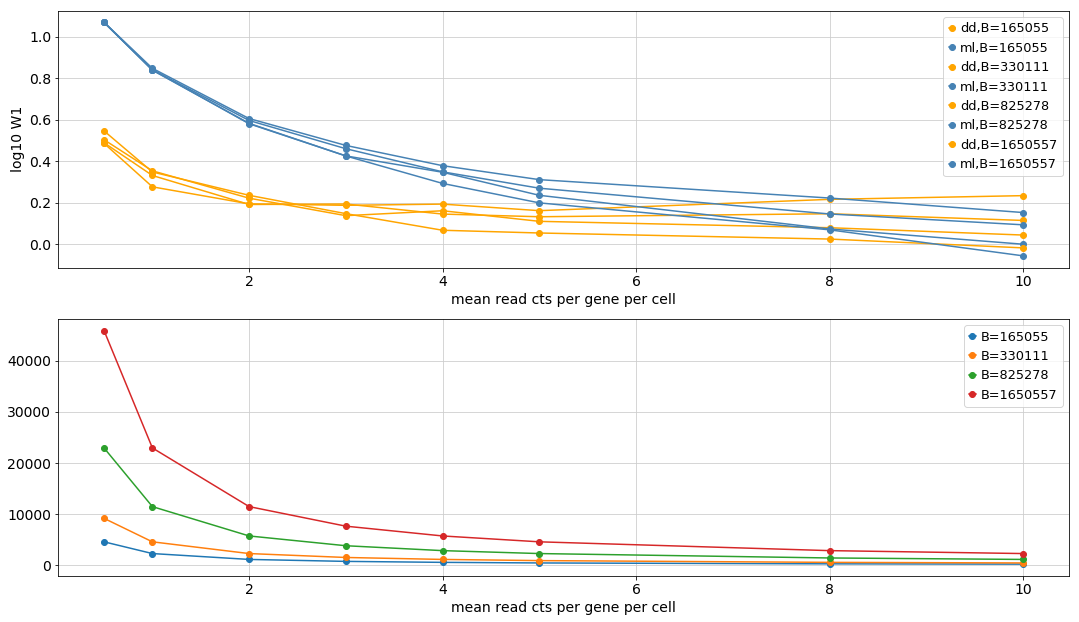

In [165]:
plt.figure(figsize=[18,10])
plt.subplot(211)
for B_sub in B_sub_list:
    err_dd_ = []
    err_ml_ = []
    Nr_bar_list_ = []
    Nc_list_ = []
    
    for key in data_subsamp.keys():
        B_,Nr_bar_,Nr_,Nc_ = key
        if B_ == B_sub:
            Nr_bar_list_.append(Nr_bar_)
            Nc_list_.append(Nc_)
            err_ml_.append(np.log10(err_ml_dic_[key].mean()))
            err_dd_.append(np.log10(err_dd_dic_[key].mean()))
    
    err_ml_ = np.array(err_ml_)
    err_dd_ = np.array(err_dd_)
    Nr_bar_list_ = np.array(Nr_bar_list_)
    Nc_list_ = np.array(Nc_list_)
    
    sort_idx = np.argsort(Nr_bar_list_)
    err_ml_ = err_ml_[sort_idx]
    err_dd_ = err_dd_[sort_idx]
    Nr_bar_list_ = Nr_bar_list_[sort_idx]
    Nc_list_ = Nc_list_[sort_idx]
    
    plt.plot(Nr_bar_list_,err_dd_,label='dd,B=%d'%B_sub,marker='o',color='orange')
    plt.plot(Nr_bar_list_,err_ml_,label='ml,B=%d'%B_sub,marker='o',color='steelblue')
plt.legend()    
plt.ylabel('log10 W1')
plt.xlabel('mean read cts per gene per cell')
plt.subplot(212)

for B_sub in B_sub_list:
    err_dd_ = []
    err_ml_ = []
    Nr_bar_list_ = []
    Nc_list_ = []
    
    for key in data_subsamp.keys():
        B_,Nr_bar_,Nr_,Nc_ = key
        if B_ == B_sub:
            Nr_bar_list_.append(Nr_bar_)
            Nc_list_.append(Nc_)
            err_ml_.append(err_ml_dic_[key].mean())
            err_dd_.append(err_dd_dic_[key].mean())
    
    err_ml_ = np.array(err_ml_)
    err_dd_ = np.array(err_dd_)
    Nr_bar_list_ = np.array(Nr_bar_list_)
    Nc_list_ = np.array(Nc_list_)
    
    sort_idx = np.argsort(Nr_bar_list_)
    err_ml_ = err_ml_[sort_idx]
    err_dd_ = err_dd_[sort_idx]
    Nr_bar_list_ = Nr_bar_list_[sort_idx]
    Nc_list_ = Nc_list_[sort_idx]
    
    plt.plot(Nr_bar_list_,Nc_list_,label='B=%d'%B_sub,marker='o')
plt.legend()    
plt.xlabel('mean read cts per gene per cell')
plt.show()

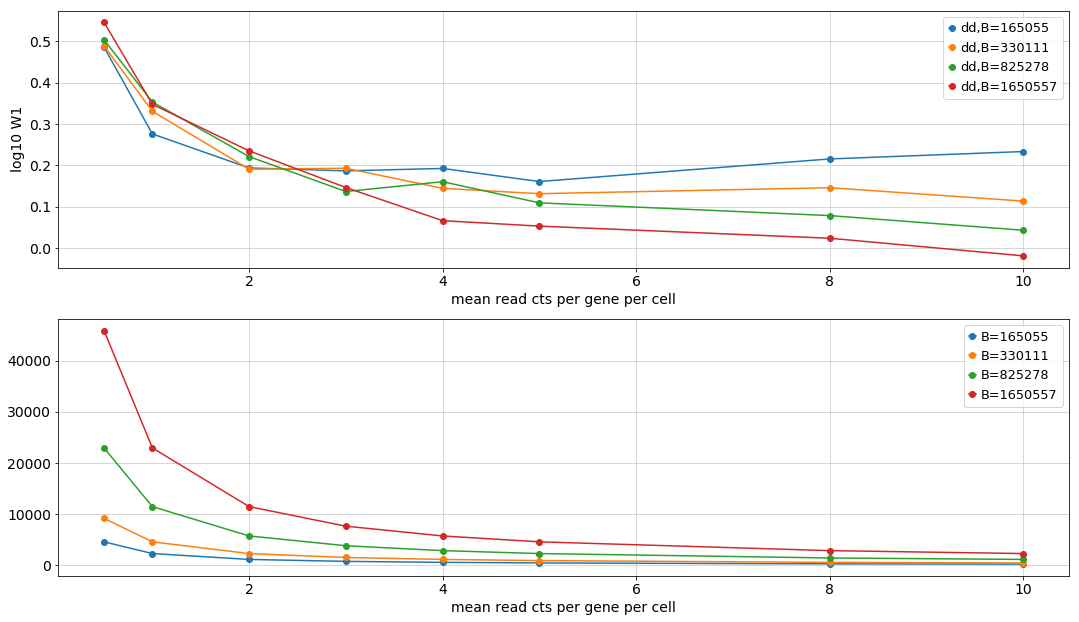

In [166]:
plt.figure(figsize=[18,10])
plt.subplot(211)
for B_sub in B_sub_list:
    err_dd_ = []
    err_ml_ = []
    Nr_bar_list_ = []
    Nc_list_ = []
    
    for key in data_subsamp.keys():
        B_,Nr_bar_,Nr_,Nc_ = key
        if B_ == B_sub:
            Nr_bar_list_.append(Nr_bar_)
            Nc_list_.append(Nc_)
            err_ml_.append(np.log10(err_ml_dic_[key].mean()))
            err_dd_.append(np.log10(err_dd_dic_[key].mean()))
    
    err_ml_ = np.array(err_ml_)
    err_dd_ = np.array(err_dd_)
    Nr_bar_list_ = np.array(Nr_bar_list_)
    Nc_list_ = np.array(Nc_list_)
    
    sort_idx = np.argsort(Nr_bar_list_)
    err_ml_ = err_ml_[sort_idx]
    err_dd_ = err_dd_[sort_idx]
    Nr_bar_list_ = Nr_bar_list_[sort_idx]
    Nc_list_ = Nc_list_[sort_idx]
    
    plt.plot(Nr_bar_list_,err_dd_,label='dd,B=%d'%B_sub,marker='o')#,color='orange')
#     plt.plot(Nr_bar_list_,err_ml_,label='ml,B=%d'%B_sub,marker='o',color='steelblue')
plt.legend()    
plt.ylabel('log10 W1')
plt.xlabel('mean read cts per gene per cell')

plt.subplot(212)

for B_sub in B_sub_list:
    err_dd_ = []
    err_ml_ = []
    Nr_bar_list_ = []
    Nc_list_ = []
    
    for key in data_subsamp.keys():
        B_,Nr_bar_,Nr_,Nc_ = key
        if B_ == B_sub:
            Nr_bar_list_.append(Nr_bar_)
            Nc_list_.append(Nc_)
            err_ml_.append(err_ml_dic_[key].mean())
            err_dd_.append(err_dd_dic_[key].mean())
    
    err_ml_ = np.array(err_ml_)
    err_dd_ = np.array(err_dd_)
    Nr_bar_list_ = np.array(Nr_bar_list_)
    Nc_list_ = np.array(Nc_list_)
    
    sort_idx = np.argsort(Nr_bar_list_)
    err_ml_ = err_ml_[sort_idx]
    err_dd_ = err_dd_[sort_idx]
    Nr_bar_list_ = Nr_bar_list_[sort_idx]
    Nc_list_ = Nc_list_[sort_idx]
    
    plt.plot(Nr_bar_list_,Nc_list_,label='B=%d'%B_sub,marker='o')
plt.xlabel('mean read cts per gene per cell')
plt.legend()    
plt.show()

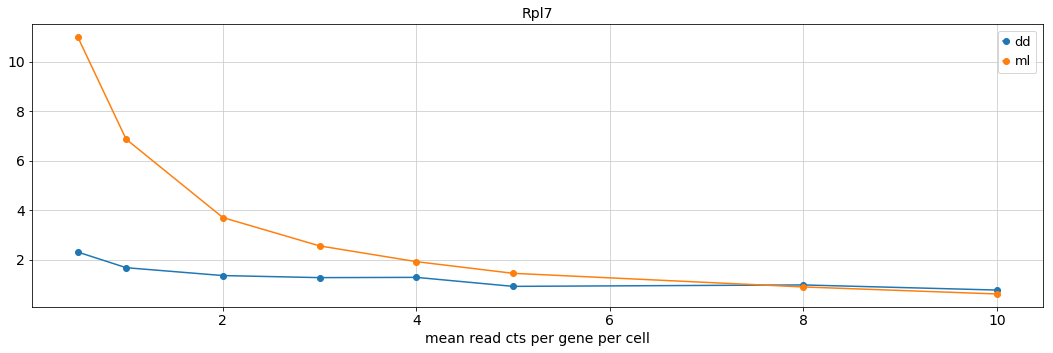

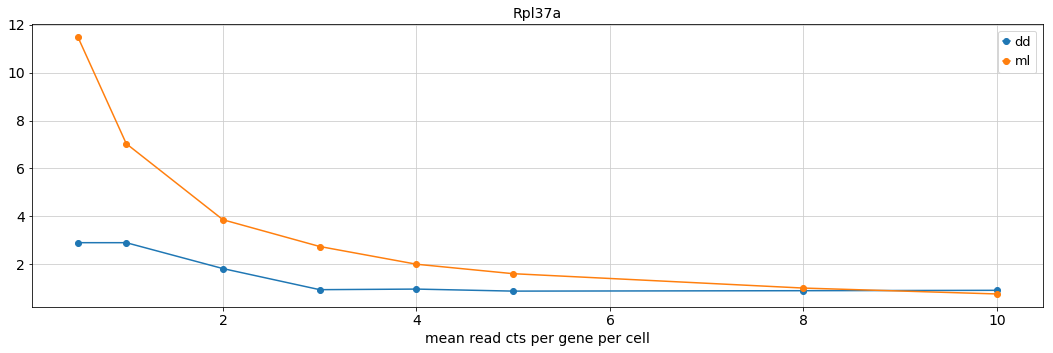

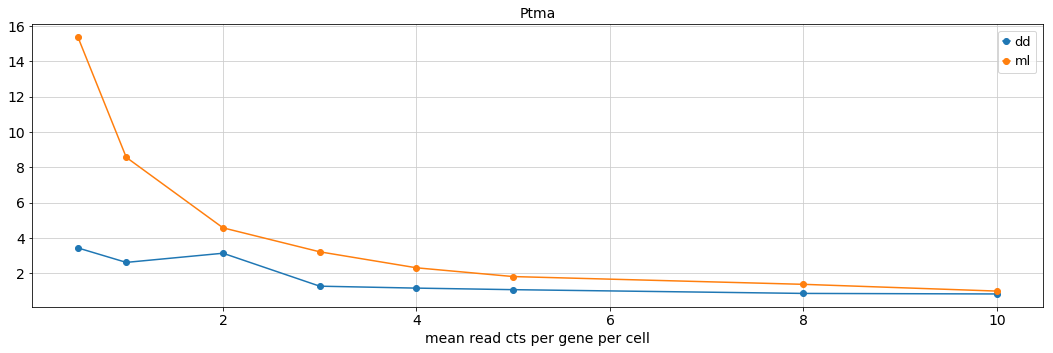

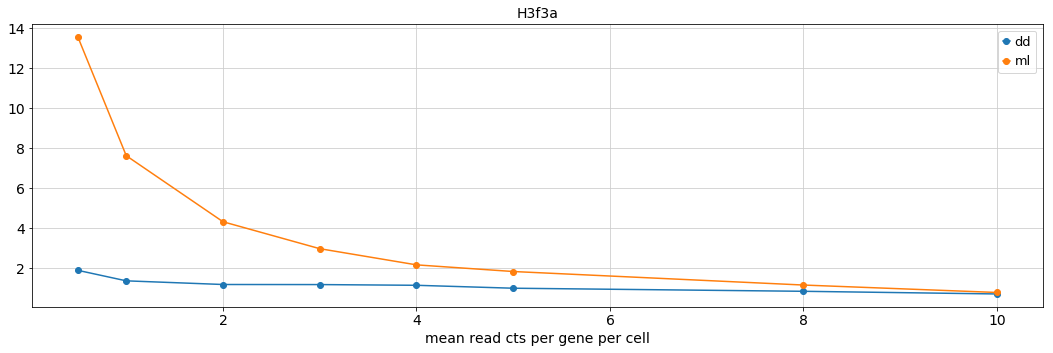

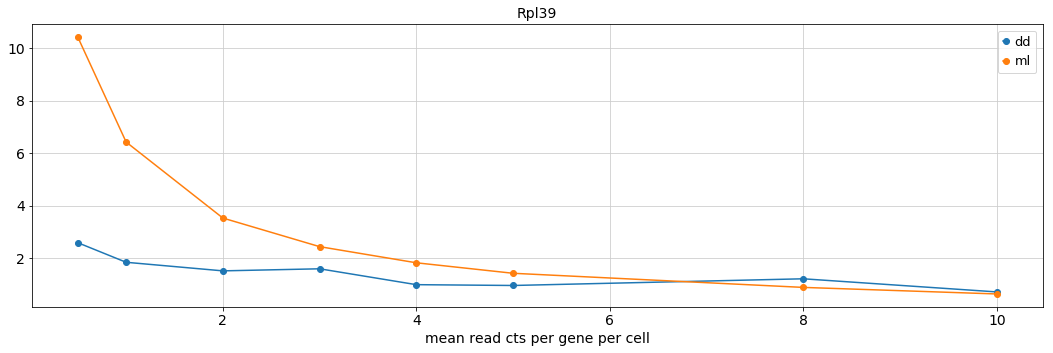

In [159]:
for gene in data_13m.var_names[0:5]:

#     gene = data_13m3m3m.var_names[1]
    temp_full = data_13m[:,gene].X
    temp_full = np.array(temp_full,dtype=int)
    temp_full = temp_full.reshape(-1)
    p_full,x_full=dd1d.counts2pdf_1d(temp_full)

    err_dd = []
    err_ml = []
    Nr_list_ = []

    for key in data_subsamp.keys():
        B_,Nr_bar_,Nr_,Nc_ = key
        if B_ == B_sub_list[3]:
            temp = data_subsamp[key][:,gene].X
            temp = np.array(temp,dtype=int)
            temp = temp.reshape(-1)

            p_sub,x_sub=dd1d.counts2pdf_1d(temp)
            p_hat,x_hat=dd1d.dd_1d(temp,noise='poi',zero_inflate=True,c_reg=1e-6,verbose=False,gamma=None,debug_mode=False)

            m_full = p_full.dot(x_full)
            m_sub = p_sub.dot(x_sub)
            m_hat = p_hat.dot(x_hat)

            err_dd.append(dist_W1(p_hat,p_full,x_hat/m_hat*m_full,x_full))
            err_ml.append(dist_W1(p_sub,p_full,x_sub/m_sub*m_full,x_full))
            Nr_list_.append(Nr_bar_)
    plt.figure(figsize=[18,5])
    plt.plot(Nr_list_,err_dd,label='dd',marker='o')
    plt.plot(Nr_list_,err_ml,label='ml',marker='o')
    plt.legend()
    plt.title(gene)
    plt.xlabel('mean read cts per gene per cell')
    plt.show()
